In [1]:
import argparse
import os
import pathlib
import sys

import matplotlib.pyplot as plt

# Import dependencies
import numpy as np
import scipy
import skimage
import tifffile
from skimage.filters import sobel

cwd = pathlib.Path.cwd()

if (cwd / ".git").is_dir():
    root_dir = cwd
else:
    root_dir = None
    for parent in cwd.parents:
        if (parent / ".git").is_dir():
            root_dir = parent
            break
sys.path.append(str(root_dir / "utils"))
from arg_parsing_utils import check_for_missing_args, parse_args
from file_reading import read_zstack_image
from notebook_init_utils import bandicoot_check, init_notebook

root_dir, in_notebook = init_notebook()

image_base_dir = bandicoot_check(
    pathlib.Path(os.path.expanduser("~/mnt/bandicoot")).resolve(), root_dir
)

In [2]:
if not in_notebook:
    args = parse_args()
    clip_limit = args["clip_limit"]
    well_fov = args["well_fov"]
    patient = args["patient"]
    input_subparent_name = args["input_subparent_name"]
    mask_subparent_name = args["mask_subparent_name"]
    check_for_missing_args(
        well_fov=well_fov,
        patient=patient,
        clip_limit=clip_limit,
        input_subparent_name=input_subparent_name,
        mask_subparent_name=mask_subparent_name,
    )
else:
    patient = "NF0037_T1-Z-1"
    well_fov = "F4-2"
    clip_limit = 0.01
    input_subparent_name = "zstack_images"
    mask_subparent_name = "segmentation_masks"

input_dir = pathlib.Path(
    f"{image_base_dir}/data/{patient}/{input_subparent_name}/{well_fov}"
).resolve(strict=True)

mask_path = pathlib.Path(
    f"{image_base_dir}/data/{patient}/{mask_subparent_name}/{well_fov}"
).resolve()
mask_output = mask_path / "cell_masks_watershed.tiff"
mask_path.mkdir(exist_ok=True, parents=True)
nuclei_mask = read_zstack_image(
    pathlib.Path(
        f"{image_base_dir}/data/{patient}/{mask_subparent_name}/{well_fov}/nuclei_masks_reconstructed_corrected.tiff"
    )
)

## Set up images, paths and functions

In [3]:
image_extensions = {".tif", ".tiff"}
files = sorted(input_dir.glob("*"))
files = [str(x) for x in files if x.suffix in image_extensions]

In [4]:
# find the cytoplasmic channels in the image set
for f in files:
    if "555" in f:
        cyto2 = read_zstack_image(f)

# pick which channels to use for cellpose
cyto = skimage.exposure.equalize_adapthist(cyto2, clip_limit=clip_limit)

In [5]:
# gaussian filter to smooth the image
cyto = skimage.filters.gaussian(cyto, sigma=1.0)

In [6]:
# scale the pixels to max 255
nuclei_mask = (nuclei_mask / nuclei_mask.max() * 255).astype(np.uint8)

In [7]:
# generate the elevation map using the Sobel filter
elevation_map = sobel(cyto)

In [8]:
# set up seeded watersheding where the nuclei masks are used as seeds
# note: the cytoplasm is used as the signal for this.

labels = skimage.segmentation.watershed(
    image=elevation_map,
    markers=nuclei_mask,
)

In [9]:
# change the largest label (by area) to 0
unique, counts = np.unique(labels, return_counts=True)
largest_label = unique[np.argmax(counts)]
labels[labels == largest_label] = 0

In [10]:
print(f"There are {len(np.unique(nuclei_mask))} nuclei in the mask")
print(f"There are {len(np.unique(labels))} cell masks in the watershed segmentation")

There are 33 nuclei in the mask
There are 32 cell masks in the watershed segmentation


In [11]:
# save the labels as a tiff file
tifffile.imwrite(mask_output, labels)

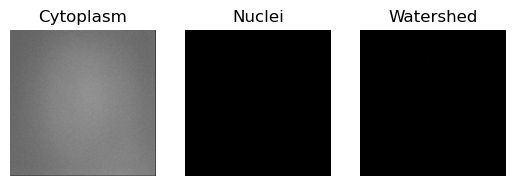

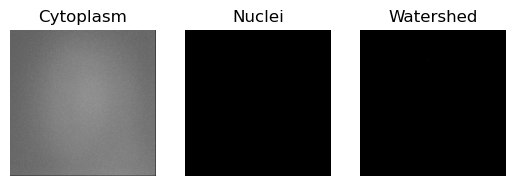

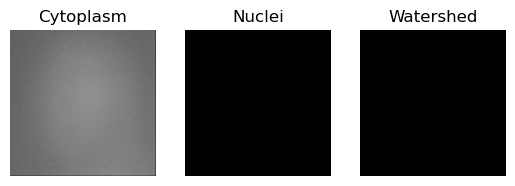

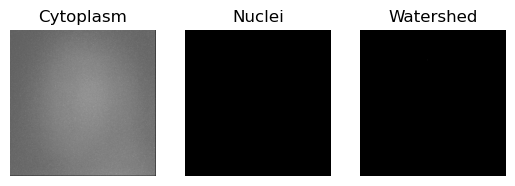

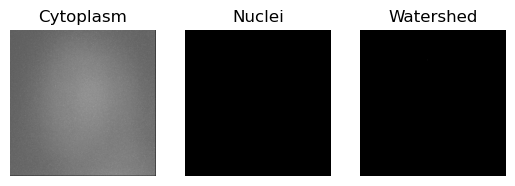

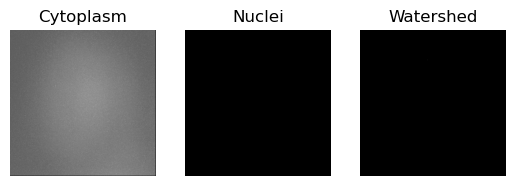

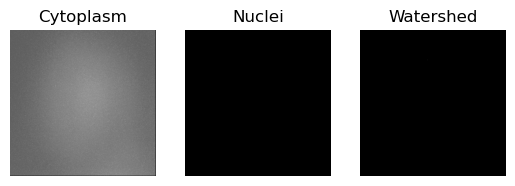

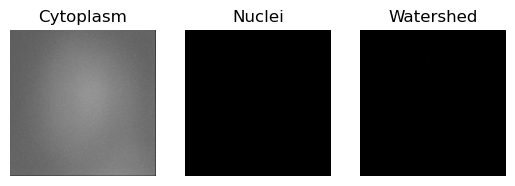

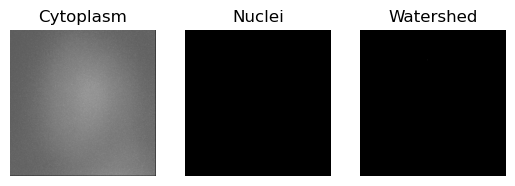

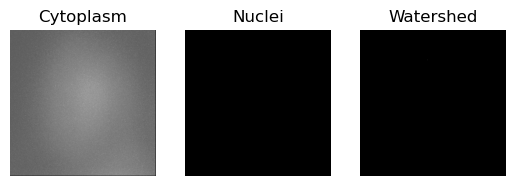

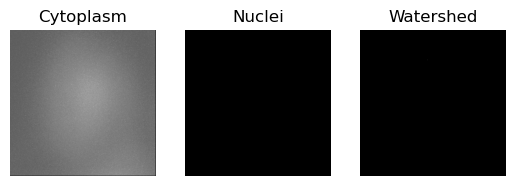

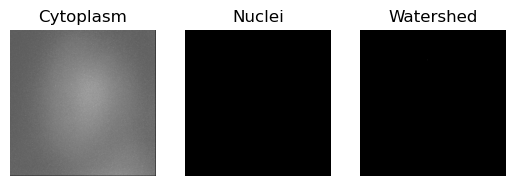

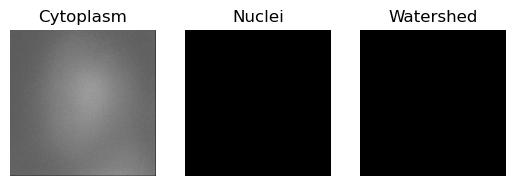

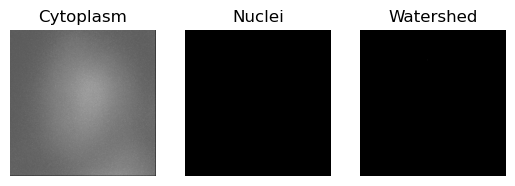

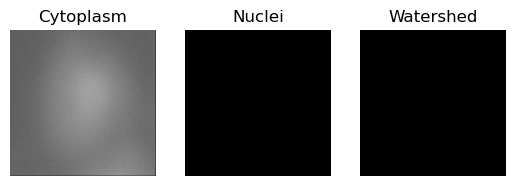

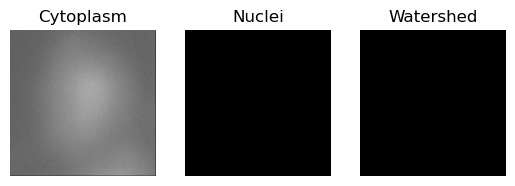

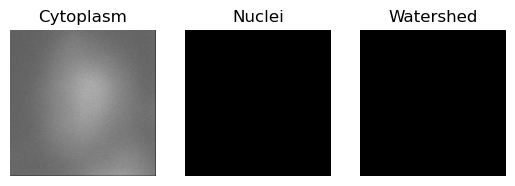

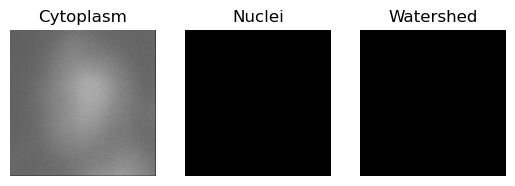

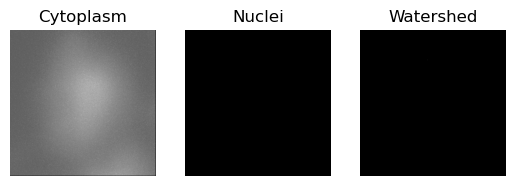

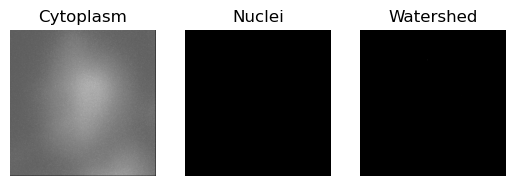

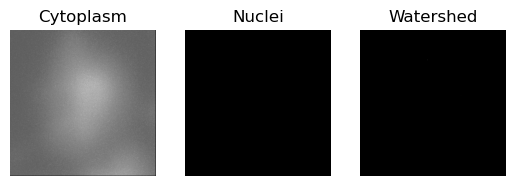

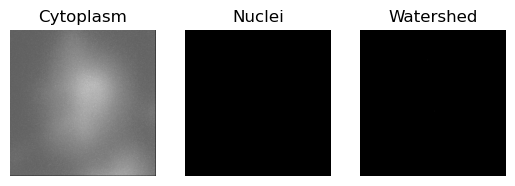

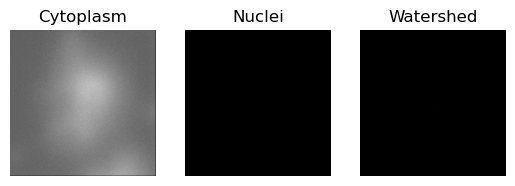

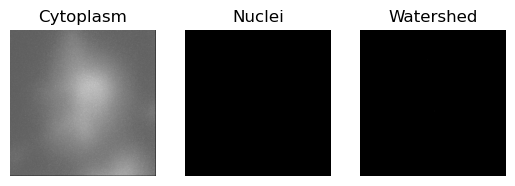

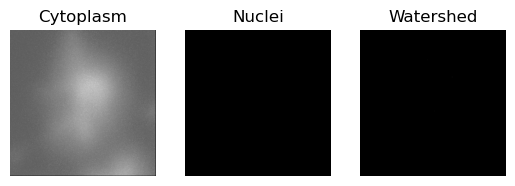

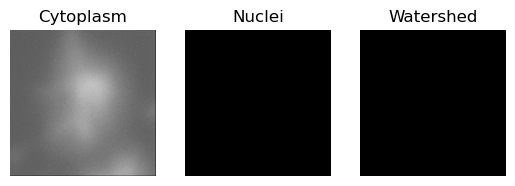

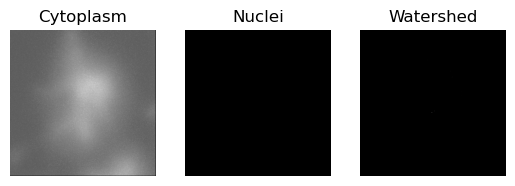

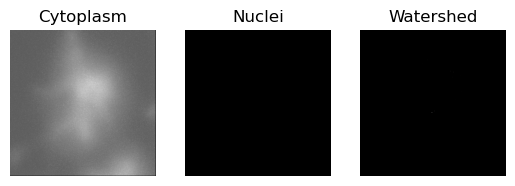

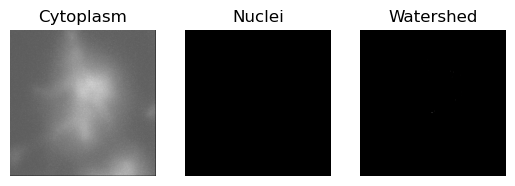

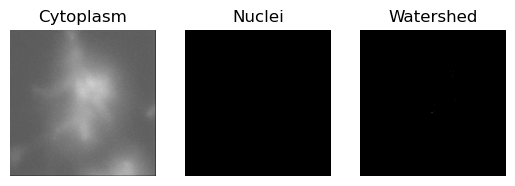

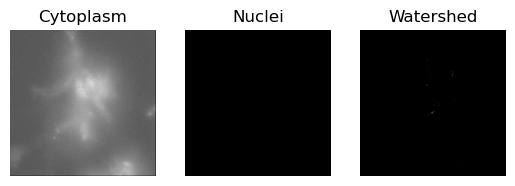

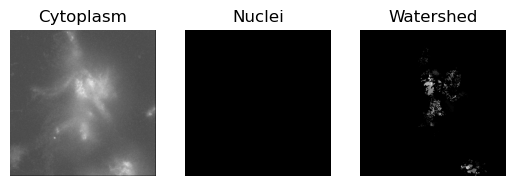

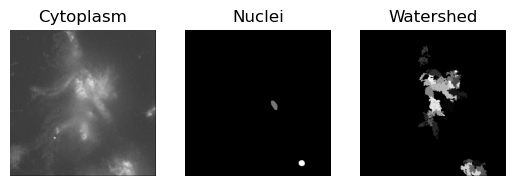

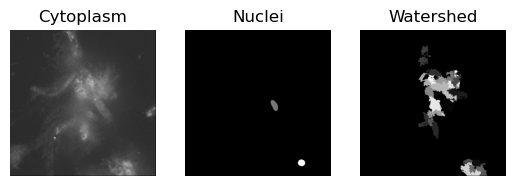

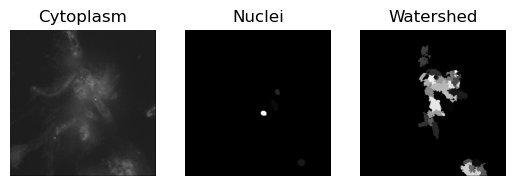

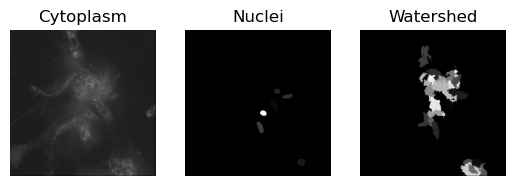

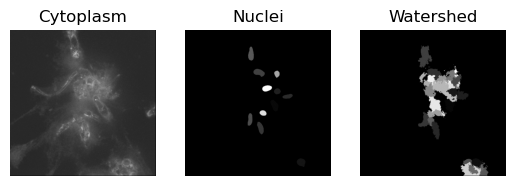

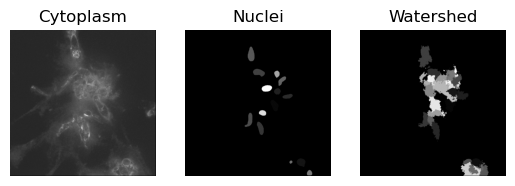

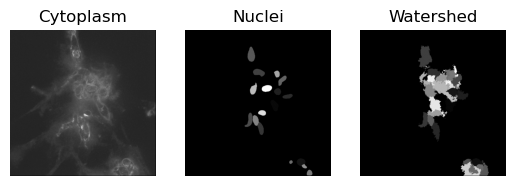

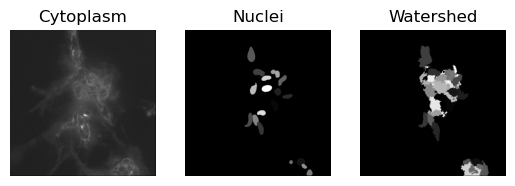

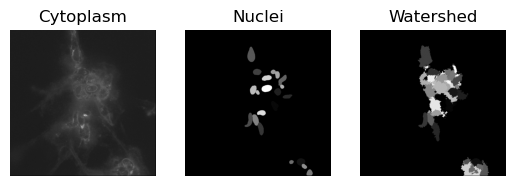

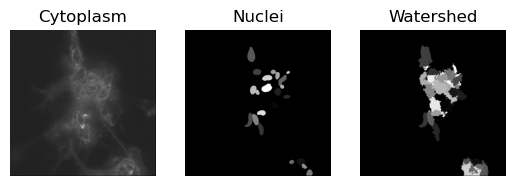

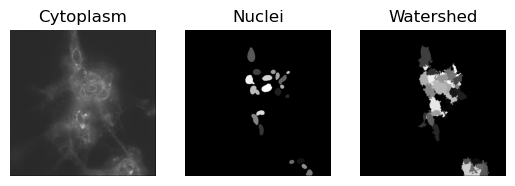

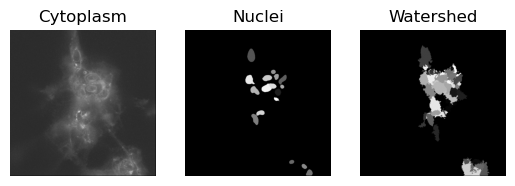

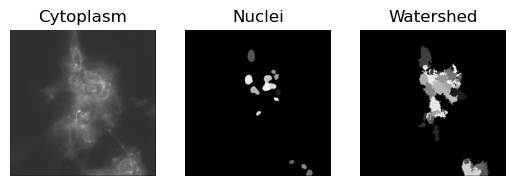

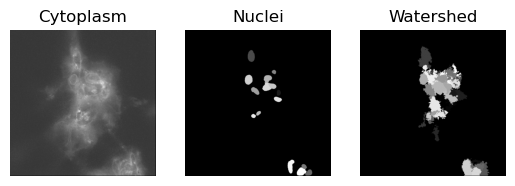

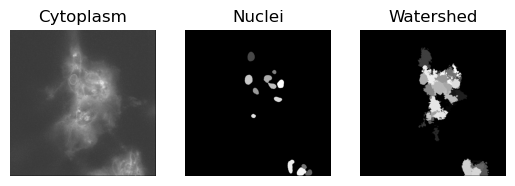

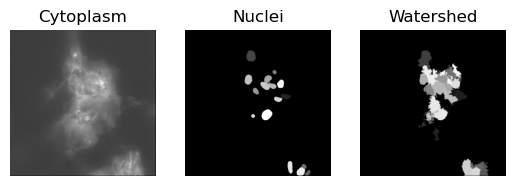

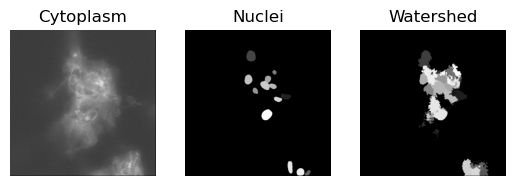

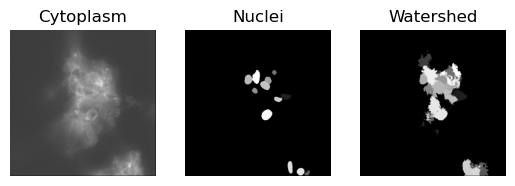

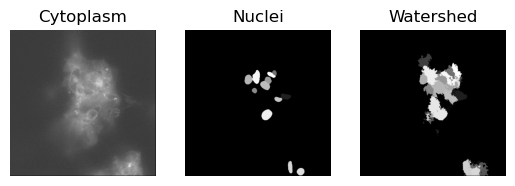

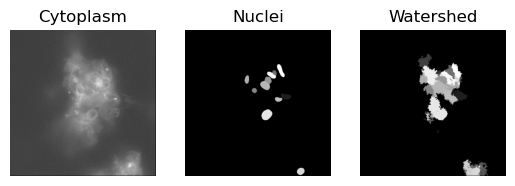

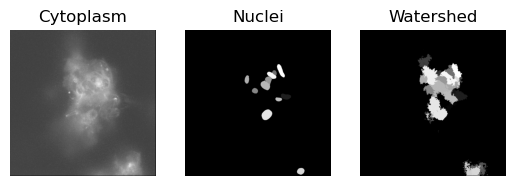

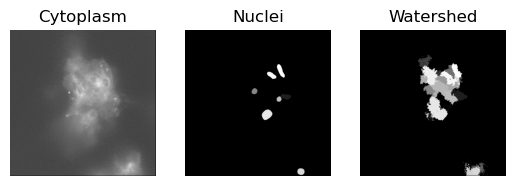

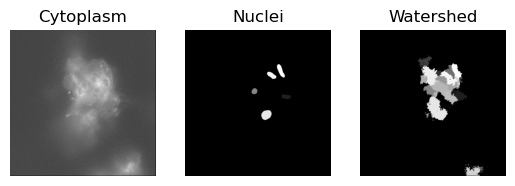

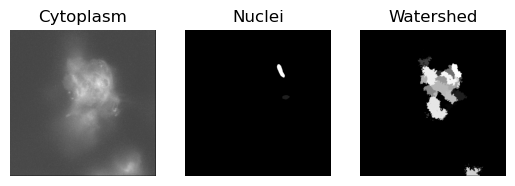

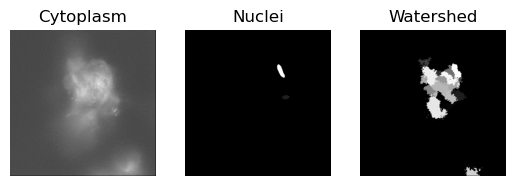

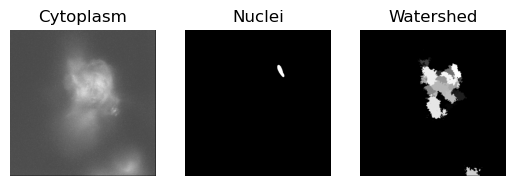

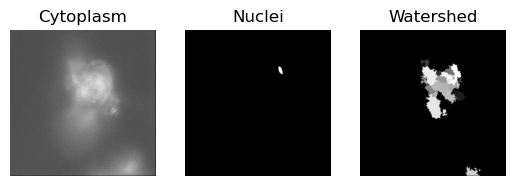

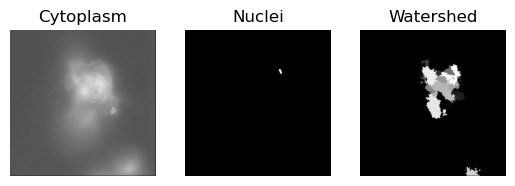

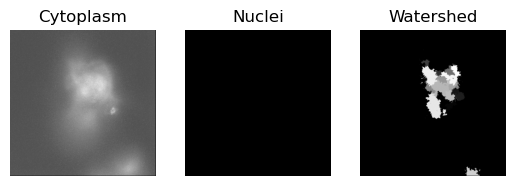

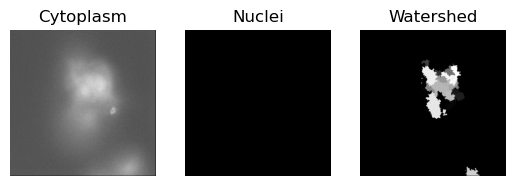

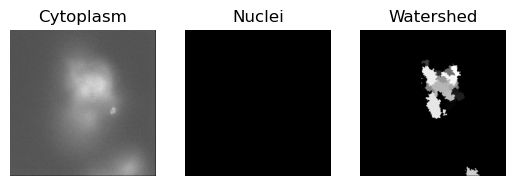

In [12]:
if in_notebook:
    for z in range(cyto.shape[0]):
        plt.subplot(1, 3, 1)
        plt.imshow(cyto[z, :, :], cmap="gray")
        plt.title("Cytoplasm")
        plt.axis("off")
        plt.subplot(1, 3, 2)
        plt.imshow(nuclei_mask[z, :, :], cmap="gray")
        plt.title("Nuclei")
        plt.axis("off")
        plt.subplot(1, 3, 3)
        plt.imshow(labels[z, :, :], cmap="gray")
        plt.title("Watershed")
        plt.axis("off")
        plt.show()